In [1]:
import datetime
from glob import glob
import os
import re

import pandas as pd
import qgrid


# Excel to Pandas (and Back)

### Download the data set

For this demo we're using the [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/Online+Retail/) which can be found on the UCI Machine Learning Repository. 

Run the cells below to download the data programmatically. 

**Note:** If you navigate to the page linked above, you may find that the "Data Folder" link is broken. It should link to the following:  https://archive.ics.uci.edu/ml/machine-learning-databases/00352. 

In [2]:
if not os.path.exists('data'):
    os.mkdir('data')
    
if not os.path.exists('data/monthly'):
    os.mkdir('data/monthly')

In [3]:
!wget -nc -O data/online-retail.xlsx \
https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2020-06-11 05:12:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘data/online-retail.xlsx’

data/online-retail. 100%[===================>]  22.62M  6.48MB/s    in 4.1s    

2020-06-11 05:13:01 (5.57 MB/s) - ‘data/online-retail.xlsx’ saved [23715344/23715344]



### Prepare the data

The data set describes online transactions taking place from December 2010 to December 2011. We split them into monthly spreadsheets for the sake of demonstration, since we'll be covering how to combine data from multiple files and how to automate tasks across multiple files.

In [4]:
data_path = 'data/online-retail.xlsx'

In [5]:
def convert_to_monthly(data_path):
    
    printout = 'Reading data from {}:'.format(data_path)
    print(printout)
    print('-'*len(printout))
    
    df = pd.read_excel(data_path)
    df['MonthYear'] = df['InvoiceDate'].dt.strftime('%b-%Y')

    for month_year in df['MonthYear'].unique():
        monthly_df = df[df['MonthYear'] == month_year].drop('MonthYear', 1)
        file_path = os.path.join('data/monthly', 'transactions-' + month_year + '.xlsx')
        print(' Writing file: {}'.format(file_path))
        monthly_df.to_excel(file_path, index=True)
        
    print('-'*len(printout))
    print('Complete.')
    

In [6]:
convert_to_monthly(data_path)

Reading data from data/online-retail.xlsx:
------------------------------------------
 Writing file: data/monthly/transactions-Dec-2010.xlsx
 Writing file: data/monthly/transactions-Jan-2011.xlsx
 Writing file: data/monthly/transactions-Feb-2011.xlsx
 Writing file: data/monthly/transactions-Mar-2011.xlsx
 Writing file: data/monthly/transactions-Apr-2011.xlsx
 Writing file: data/monthly/transactions-May-2011.xlsx
 Writing file: data/monthly/transactions-Jun-2011.xlsx
 Writing file: data/monthly/transactions-Jul-2011.xlsx
 Writing file: data/monthly/transactions-Aug-2011.xlsx
 Writing file: data/monthly/transactions-Sep-2011.xlsx
 Writing file: data/monthly/transactions-Oct-2011.xlsx
 Writing file: data/monthly/transactions-Nov-2011.xlsx
 Writing file: data/monthly/transactions-Dec-2011.xlsx
------------------------------------------
Complete.


## Reading from an Excel file

### Specify the path to the file

In [7]:
sheet_path = 'data/monthly/transactions-Dec-2010.xlsx'

In [8]:
def load_df(sheet_path):
    df = pd.read_excel(sheet_path, index_col=0)
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)
    df['StockCode'] = df['StockCode'].astype(str)
    return df

In [9]:
df = load_df(sheet_path)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Investigating missing values

In [10]:
df.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002942
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.367953
Country        0.000000
dtype: float64

In [11]:
df[df['Description'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom


**It looks like items without a description have a unit price of 0.0. Let's confirm this and omit these, for now.**

In [12]:
print((df[df['Description'].isna()]['UnitPrice'] == 0).all())

def remove_items_without_description(df):
    return df[~df['Description'].isna()]

df = remove_items_without_description(df)

True


## Analysis

Let's start looking into something simple: what products are selling well? We'll need to do some *aggregation* over the product identifiers - the StockCodes. First, let's build a data frame of the products we find here. 

In [13]:
products = df.groupby('StockCode')[['Description', 'UnitPrice']].first()
products.head()

,Description,UnitPrice
StockCode,,
10002,INFLATABLE POLITICAL GLOBE,0.85
10120,DOGGY RUBBER,0.21
10123C,HEARTS WRAPPING TAPE,0.65
10124A,SPOTS ON RED BOOKCOVER TAPE,0.42
10124G,ARMY CAMO BOOKCOVER TAPE,0.42


Note that the last two rows describe different colors / variants of the same product. Should these be counted as separate products? 

In [14]:
def separate_code_and_color(df):
    
    df[['StockCodeBase', 'Color']] = df['StockCode'].str.extract(r'(\d+)([A-Z])*')
    df['Color'] = df['Color'].fillna(-1)
    
    return df

In [15]:
df = separate_code_and_color(df)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,85123,A
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,71053,-1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,84406,B
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,G
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,E


In [16]:
def get_product_df(df):
    
    products = (df.groupby('StockCodeBase')[['Description','Color', 'UnitPrice']]
     .agg(
         Description=('Description', 'first'),
         n_colors=('Color', 'nunique'),
         UnitPrice=('UnitPrice', 'first')
     ))
    
    return products

get_product_df(df).head()

,Description,n_colors,UnitPrice
StockCodeBase,,,
0001,Dotcomgiftshop Gift Voucher £40.00,1,34.04
0003,BOXED GLASS ASHTRAY,1,2.51
0070,CAMOUFLAGE DOG COLLAR,1,12.72
0076,SUNJAR LED NIGHT NIGHT LIGHT,1,16.13
10002,INFLATABLE POLITICAL GLOBE,1,0.85


## Top-selling items

In [17]:
def top_selling_items(df, n_items=10):
    df['GrossRevenue'] = df['UnitPrice'] * df['Quantity']
    
    top_items = (df.groupby('StockCodeBase')[['Description', 'UnitPrice', 'Quantity', 'GrossRevenue']]
                 .agg(
                     Description=('Description', 'first'),
                     UnitPrice=('UnitPrice', 'first'),
                     Quantity=('Quantity', 'sum'),
                     TotalGrossRevenue=('GrossRevenue', 'sum')
                 )
                ).sort_values(by='TotalGrossRevenue', ascending=False)
    
    return top_items.iloc[:n_items, :]

top_selling_items(df)

,Description,UnitPrice,Quantity,TotalGrossRevenue
StockCodeBase,,,,
22423,REGENCY CAKESTAND 3 TIER,10.95,2002,26897.36
84029,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,3102,15973.45
85123,WHITE HANGING HEART T-LIGHT HOLDER,2.55,3343,9877.82
22086,PAPER CHAIN KIT 50'S CHRISTMAS,2.55,2453,9205.15
21479,WHITE SKULL HOT WATER BOTTLE,3.75,2160,8228.73
22114,HOT WATER BOTTLE TEA AND SYMPATHY,3.45,1202,8095.26
79321,CHILLI LIGHTS,3.82,1591,7506.44
22112,CHOCOLATE HOT WATER BOTTLE,4.95,1231,7327.13
21623,VINTAGE UNION JACK MEMOBOARD,9.95,1062,6999.63


## Working with strings

In [18]:
df[df['Description'].str.contains('UNION')].sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color,GrossRevenue
41510,539858,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,48,2010-12-22 16:19:00,3.39,18092.0,United Kingdom,84029,G,162.72
18040,537794,48138,DOORMAT UNION FLAG,1,2010-12-08 13:01:00,7.95,16713.0,United Kingdom,48138,-1,7.95
1386,536539,48138,DOORMAT UNION FLAG,2,2010-12-01 14:03:00,7.95,15165.0,United Kingdom,48138,-1,15.90
4948,536831,22207,FRYING PAN UNION FLAG,48,2010-12-02 17:40:00,3.75,16029.0,United Kingdom,22207,-1,180.00
21381,538077,21867,PINK UNION JACK LUGGAGE TAG,7,2010-12-09 14:19:00,1.25,14667.0,United Kingdom,21867,-1,8.75


In [19]:
df[df['Description'].str.contains('UNION')]['Country'].value_counts()

United Kingdom     605
France               5
Germany              4
Australia            3
Channel Islands      2
Name: Country, dtype: int64

### Item colors with regex

Earlier, we saw that the StockCode contained some information about the colors/variants of items, but it didn't help us compare across multiple items. 

Now, we'll use *regular expressions* (regex) to attempt to locate and extract a standard color from the item description. 

In [20]:
color_reg = re.compile(r'((?:BLACK)|(?:WHITE)|(?:RED)|(?:GREEN)|(?:BLUE)|(?:PINK))')


In [21]:
df['DescriptionColor'] = (df['Description']
                          .str.extract(color_reg)
                          .fillna('None'))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color,GrossRevenue,DescriptionColor
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,85123,A,15.30,WHITE
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,71053,-1,20.34,WHITE
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,84406,B,22.00,None
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,G,20.34,None
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,E,20.34,RED


In [22]:
def top_selling_colors(df):
    color_reg = re.compile(r'((?:BLACK)|(?:WHITE)|(?:RED)|(?:GREEN)|(?:BLUE)|(?:PINK))')
    df['DescriptionColor'] = df['Description'].str.extract(color_reg).fillna('None')
    
    top_colors = (df
                  .groupby('DescriptionColor')['GrossRevenue']
                  .sum()
                  .sort_values(ascending=False)
                  .reset_index())
    return top_colors

In [23]:
top_selling_colors(df)

,DescriptionColor,GrossRevenue
0,None,545173.70
1,RED,76636.52
2,WHITE,39038.75
3,PINK,32591.31
4,BLACK,28095.32
5,BLUE,17748.37
6,GREEN,9673.05


## Working with Dates

The data description page mentions that many of the customers are wholesalers. We might expect that business customers exhibit different shopping patterns from non-business customers. For instance, we might wonder if business customers make more purchases on week days and during business hours.

Whether or not this is the case, Pandas makes it easy to extract this temporal information and use it to filter and process data.

We can use the `.dt` accessor to utilize datetime methods like `.year`, `.month`', `.hour`, and even `.dayofweek`.

In [24]:
df['InvoiceDate'].dt.dayofweek.value_counts()

4    8038
0    7908
3    7712
2    7375
1    6625
6    4698
Name: InvoiceDate, dtype: int64

Interestingly enough, it appears there are no Saturday transactions in the data set. Let's see what we can do with time of day.

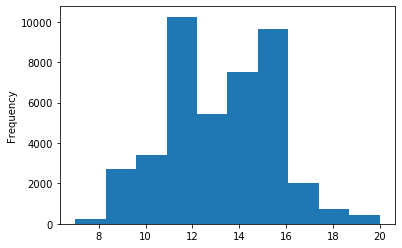

In [25]:
df['InvoiceDate'].dt.hour.plot.hist()

These methods can be used to create filters for the data as well. 

Here we make a `business_hours` filter that keeps only transactions occurring between 9AM-5PM Monday through Friday.

In [26]:
filter_9_to_5 = (df['InvoiceDate'].dt.hour >=9) & (df['InvoiceDate'].dt.hour <17)
filter_weekday = df['InvoiceDate'].dt.dayofweek <=5

In [27]:
df_weekday = df[filter_9_to_5 & filter_weekday]
df_weekday

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color,GrossRevenue,DescriptionColor
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,22086,-1,204.00,None
47,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom,22632,-1,11.10,RED
48,536372,22633,HAND WARMER UNION JACK,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom,22633,-1,11.10,None
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,85123,A,15.30,WHITE
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom,71053,-1,20.34,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...
42473,539991,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-23 16:49:00,4.95,NaN,United Kingdom,22111,-1,4.95,None
42474,539991,22802,FAUX FUR CHOCOLATE THROW,1,2010-12-23 16:49:00,19.95,NaN,United Kingdom,22802,-1,19.95,None
42475,539991,21616,4 PEAR BOTANICAL DINNER CANDLES,1,2010-12-23 16:49:00,1.25,NaN,United Kingdom,21616,-1,1.25,None
42476,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN,United Kingdom,21618,-1,1.25,None


## Writing to an Excel file

For simple Excel output, we can use the Pandas `.to_excel` method. For more advanced usage, we use the [XlsxWriter](https://xlsxwriter.readthedocs.io/) library. With the latter, we can create more sophisticated files with multiple sheets and even charts.

In [28]:
if not os.path.exists('output'):
    os.mkdir('output')


In [29]:
file_path = os.path.join('output', 'Dec-2010'+ '.xlsx')

with pd.ExcelWriter(file_path) as writer:
    df.to_excel(writer, sheet_name='original', index=False)
    get_product_df(df).reset_index().to_excel(writer, sheet_name='products', index=False)
    top_selling_items(df).reset_index().to_excel(writer,sheet_name='top-items', index=False)
    top_selling_colors(df).to_excel(writer,sheet_name='top-colors', index=False)

## Automation

Now, let's do this to all the monthly files we have!

In [30]:
def load_and_process_df(path):
    print("Loading {}".format(path))
    df = load_df(path)
    df = remove_items_without_description(df)
    df = separate_code_and_color(df)
    
    return df

In [31]:
def generate_report(df, name):
    
    file_path = os.path.join('output', '{}.xlsx'.format(name))

    print('Writing {}'.format(file_path))
    with pd.ExcelWriter(file_path) as writer:
        df.to_excel(writer, sheet_name='original', index=False)
        get_product_df(df).reset_index().to_excel(writer, sheet_name='products', index=False)
        top_selling_items(df).reset_index().to_excel(writer,sheet_name='top-items', index=False)
        top_selling_colors(df).to_excel(writer,sheet_name='top-colors', index=False)

In [32]:
monthly_report_paths = glob('data/monthly/*')
monthly_report_paths

['data/monthly/transactions-Apr-2011.xlsx',
 'data/monthly/transactions-Jan-2011.xlsx',
 'data/monthly/transactions-Aug-2011.xlsx',
 'data/monthly/transactions-May-2011.xlsx',
 'data/monthly/transactions-Jun-2011.xlsx',
 'data/monthly/transactions-Dec-2011.xlsx',
 'data/monthly/transactions-Nov-2011.xlsx',
 'data/monthly/transactions-Dec-2010.xlsx',
 'data/monthly/transactions-Mar-2011.xlsx',
 'data/monthly/transactions-Feb-2011.xlsx',
 'data/monthly/transactions-Sep-2011.xlsx',
 'data/monthly/transactions-Oct-2011.xlsx',
 'data/monthly/transactions-Jul-2011.xlsx']

In [33]:
monthly_reports = {path[-13:-5]:load_and_process_df(path) for path in monthly_report_paths}

Loading data/monthly/transactions-Apr-2011.xlsx
Loading data/monthly/transactions-Jan-2011.xlsx
Loading data/monthly/transactions-Aug-2011.xlsx
Loading data/monthly/transactions-May-2011.xlsx
Loading data/monthly/transactions-Jun-2011.xlsx
Loading data/monthly/transactions-Dec-2011.xlsx
Loading data/monthly/transactions-Nov-2011.xlsx
Loading data/monthly/transactions-Dec-2010.xlsx
Loading data/monthly/transactions-Mar-2011.xlsx
Loading data/monthly/transactions-Feb-2011.xlsx
Loading data/monthly/transactions-Sep-2011.xlsx
Loading data/monthly/transactions-Oct-2011.xlsx
Loading data/monthly/transactions-Jul-2011.xlsx


In [34]:
for name, report in monthly_reports.items():
    generate_report(report, name)

Writing output/Apr-2011.xlsx
Writing output/Jan-2011.xlsx
Writing output/Aug-2011.xlsx
Writing output/May-2011.xlsx
Writing output/Jun-2011.xlsx
Writing output/Dec-2011.xlsx
Writing output/Nov-2011.xlsx
Writing output/Dec-2010.xlsx
Writing output/Mar-2011.xlsx
Writing output/Feb-2011.xlsx
Writing output/Sep-2011.xlsx
Writing output/Oct-2011.xlsx
Writing output/Jul-2011.xlsx


## Concatenating data frames

In [35]:
df_all = pd.concat((df for df in monthly_reports.values()))
df_all.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color,GrossRevenue,DescriptionColor
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161.0,United Kingdom,22662,-1,16.5,None
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161.0,United Kingdom,22296,-1,19.8,None
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161.0,United Kingdom,21790,-1,10.2,None
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161.0,United Kingdom,22622,-1,19.9,None
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161.0,United Kingdom,22393,-1,15.3,None


In [36]:
top_selling_items(df_all)

,Description,UnitPrice,Quantity,TotalGrossRevenue
StockCodeBase,,,,
22423,REGENCY CAKESTAND 3 TIER,12.75,12980,164762.19
85099,JUMBO BAG BAROQUE BLACK WHITE,2.08,78076,152291.39
47566,PARTY BUNTING,4.95,17879,107551.30
85123,WHITE HANGING HEART T-LIGHT HOLDER,2.95,39122,99846.98
84997,CHILDRENS CUTLERY POLKADOT GREEN,4.15,15926,68872.32
23084,RABBIT NIGHT LIGHT,4.13,30314,66756.59
22086,PAPER CHAIN KIT 50'S CHRISTMAS,2.95,18902,63791.94
84879,ASSORTED COLOUR BIRD ORNAMENT,1.69,36221,58959.73
79321,CHILLI LIGHTS,5.75,10229,53768.06


In [37]:
generate_report(df_all, 'all-data')

Writing output/all-data.xlsx


## Bonus: point-and-click data frames with [Qgrid](https://github.com/quantopian/qgrid)

In [38]:
qgrid_widget = qgrid.show_grid(df,
                               show_toolbar=True,
                               grid_options={'forceFitColumns': False}
                              )
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### Run this cell to get the updates into the original data frame

In [39]:
qgrid_widget.get_changed_df()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeBase,Color,GrossRevenue,DescriptionColor
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,85123,A,15.30,WHITE
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,71053,-1,20.34,WHITE
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,84406,B,22.00,None
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,G,20.34,None
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,84029,E,20.34,RED
...,...,...,...,...,...,...,...,...,...,...,...,...
42476,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN,United Kingdom,21618,-1,1.25,None
42477,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN,United Kingdom,72741,-1,5.80,None
42478,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN,United Kingdom,21470,-1,3.75,None
42479,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN,United Kingdom,22258,-1,1.25,None
